<a href="https://colab.research.google.com/github/mhtabkrklt/ML_Tasks/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from google.colab import files
import os

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns



Описание признаков (Spaceship Titanic)

PassengerId — Уникальный ID пассажира (формат gggg_pp), где gggg — номер группы, а pp — номер пассажира в группе.

HomePlanet — Планета вылета (обычно родная планета).

CryoSleep — Находился ли пассажир в криосне (такие пассажиры не покидали кают).

Cabin — Номер каюты в формате deck/num/side, где side: P (левый борт) или S (правый борт).

Destination — Планета назначения.

Age — Возраст.

VIP — Оплачена ли VIP-услуга.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck — Траты пассажира на различные удобства корабля.

Name — Имя и фамилия.

Transported — Целевая переменная: был ли пассажир перенесен в другое измерение (True/False).

Цель: Предсказать, был ли пассажир космического корабля "транспортирован" в другое измерение (Transported: True/False).

In [16]:
df = pd.read_csv("train.csv")
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [17]:
cabin_split = df['Cabin'].str.split('/', expand=True)
df['Deck'] = cabin_split[0]
df['Side'] = cabin_split[2]

# Заполняем пропуски в Deck и Side значением 'Unknown'
df['Deck'] = df['Deck'].fillna('U')
df['Side'] = df['Side'].fillna('U')

spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df[spend_cols] = df[spend_cols].fillna(0)

# Складываем
df['TotalSpend'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']

In [25]:
df['CryoSleep'] = df['CryoSleep'].fillna(False).astype(int)
df['VIP'] = df['VIP'].fillna(False).astype(int)

df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
df['Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])

# 5. Работа с возрастом (Age)
# Пропуски заполняем медианой (средним по больнице)
df['Age'] = df['Age'].fillna(df['Age'].median())

if 'Transported' in df.columns:
    df['Transported'] = df['Transported'].astype(int)

cols_to_drop = ['PassengerId', 'Name', 'Cabin']
df = df.drop(columns=cols_to_drop, errors='ignore')

print(f"Размер данных после очистки: {df.shape}")
print(df.head())

Размер данных после очистки: (8693, 14)
  HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  FoodCourt  \
0     Europa          0  TRAPPIST-1e  39.0    0          0.0        0.0   
1      Earth          0  TRAPPIST-1e  24.0    0        109.0        9.0   
2     Europa          0  TRAPPIST-1e  58.0    1         43.0     3576.0   
3     Europa          0  TRAPPIST-1e  33.0    0          0.0     1283.0   
4      Earth          0  TRAPPIST-1e  16.0    0        303.0       70.0   

   ShoppingMall     Spa  VRDeck  Transported Deck Side  TotalSpend  
0           0.0     0.0     0.0            0    B    P         0.0  
1          25.0   549.0    44.0            1    F    S       736.0  
2           0.0  6715.0    49.0            0    A    S     10383.0  
3         371.0  3329.0   193.0            0    A    S      5176.0  
4         151.0   565.0     2.0            1    F    S      1091.0  


Распределение целевой переменной (Transported):
Transported
1    0.503624
0    0.496376
Name: proportion, dtype: float64


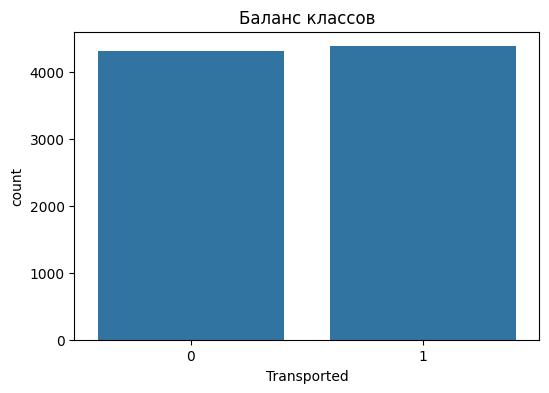

In [26]:
target_col = 'Transported'
print("Распределение целевой переменной (Transported):")
print(df[target_col].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df)
plt.title("Баланс классов")
plt.show()


In [27]:
# Отделяем признаки (X) и ответы (y)
X = df.drop(columns=[target_col])
y = df[target_col]

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
numeric_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    PowerTransformer(method='yeo-johnson'),
    StandardScaler()
)

categorical_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

# ColumnTransformer
col_trans = make_column_transformer(
    (numeric_pipe, ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalSpend"]),
    (categorical_pipe, ["HomePlanet", "Destination", "Deck", "Side"]),
    remainder='passthrough'
)

In [29]:
print(" Logistic Regression ")
logclf = LogisticRegression(max_iter=1000, random_state=42)

pipe_log = make_pipeline(col_trans, logclf)

pipe_log.fit(X_tr, y_tr)

y_pred = pipe_log.predict(X_val)
y_prob = pipe_log.predict_proba(X_val)[:, 1]

acc = accuracy_score(y_val, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary', zero_division=0)
auc = roc_auc_score(y_val, y_prob)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

 Logistic Regression 
Accuracy:  0.7573
Precision: 0.7748
Recall:    0.7306
F1:        0.7521
ROC AUC:   0.8347


In [30]:
print("\nDecision Tree ")
# Ограничиваем глубину (max_depth=10), чтобы не переобучилось
dt_clf = DecisionTreeClassifier(max_depth=10, random_state=42)

pipe_dt = make_pipeline(col_trans, dt_clf)
pipe_dt.fit(X_tr, y_tr)

y_pred = pipe_dt.predict(X_val)
y_prob = pipe_dt.predict_proba(X_val)[:, 1]

acc = accuracy_score(y_val, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary', zero_division=0)
auc = roc_auc_score(y_val, y_prob)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


Decision Tree 
Accuracy:  0.7849
Precision: 0.7872
Recall:    0.7854
F1:        0.7863
ROC AUC:   0.8418


In [31]:
print("\nKNN (K-Nearest Neighbors)")
knn_clf = KNeighborsClassifier(n_neighbors=15)

pipe_knn = make_pipeline(col_trans, knn_clf)
pipe_knn.fit(X_tr, y_tr)

y_pred = pipe_knn.predict(X_val)
y_prob = pipe_knn.predict_proba(X_val)[:, 1]

acc = accuracy_score(y_val, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary', zero_division=0)
auc = roc_auc_score(y_val, y_prob)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


KNN (K-Nearest Neighbors)
Accuracy:  0.7619
Precision: 0.7924
Recall:    0.7146
F1:        0.7515
ROC AUC:   0.8460


In [32]:
print("\nSVM (Support Vector Machine) ")
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)

pipe_svm = make_pipeline(col_trans, svm_clf)
pipe_svm.fit(X_tr, y_tr)

y_pred = pipe_svm.predict(X_val)
y_prob = pipe_svm.predict_proba(X_val)[:, 1]

acc = accuracy_score(y_val, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary', zero_division=0)
auc = roc_auc_score(y_val, y_prob)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1:        {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")


SVM (Support Vector Machine) 
Accuracy:  0.7711
Precision: 0.7908
Recall:    0.7420
F1:        0.7656
ROC AUC:   0.8635


# **Вывод**
SVM (Метод опорных векторов) стал победителем, показав лучшую точность (0.77) и самое качественное разделение классов (ROC AUC 0.85). Дерево решений оказалось полезным для поиска максимума целевых пассажиров (лучшая полнота/Recall), но ценой большого количества ложных тревог. KNN показал самые слабые результаты и является наименее подходящим выбором для этих данных.